<a href="https://colab.research.google.com/github/dominicfanucchi/aai-530_group3/blob/main/LSTM_Vehicle_Count_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Time-Series Vehicle Count Prediction Notebook
Names: Dominic Fanucchi, Daniel Grant, Isaack Karanja   
Date:    February 26, 2024
- The core objective of this notebook is to forecast traffic volume (number of vehicles) with no specific junctions using time series analysis. We are particularly interested in identifying the best-performing predictive model for our dataset collected hourly from February to June 2014 via sensors.

- __EDA was done in the other deep learning model notebook (SPEED-VEHICLE-PREDICTION-LSTM-CNN-TEAM3).__
- __Huggingface dataset used was cleaned and posted from the other deep learning model notebook as well.__
- Vehicle counts from all junctions will be included in the same df.
- This model will predict vehicle counts per hour for each day of the week.
- This models performance will be compared with the other deep learning models that use more features to predict.




# Setup

In [ ]:
!pip install datasets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# og cleaned eda dataset
dataset = load_dataset(
    "dgrant6/down_sampled_file_traffic_dataset2",
    data_files={
        "train": "train-00000-of-00001.parquet",
        "test": "test-00000-of-00001.parquet"
    }
)

# Data Preparation and Preprocessing

In [ ]:
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

In [ ]:
# sort by TIMESTAMP
train_df['TIMESTAMP'] = pd.to_datetime(train_df['TIMESTAMP'])
test_df['TIMESTAMP'] = pd.to_datetime(test_df['TIMESTAMP'])
train_df.sort_values(by='TIMESTAMP', inplace=True)
test_df.sort_values(by='TIMESTAMP', inplace=True)

In [ ]:
# extract hour, day, and month as new columns
train_df['Hour'] = train_df['TIMESTAMP'].dt.hour
train_df['Date_no'] = train_df['TIMESTAMP'].dt.day
train_df['Month'] = train_df['TIMESTAMP'].dt.month
train_df['Day'] = train_df['TIMESTAMP'].dt.day_name()

test_df['Hour'] = test_df['TIMESTAMP'].dt.hour
test_df['Date_no'] = test_df['TIMESTAMP'].dt.day
test_df['Month'] = test_df['TIMESTAMP'].dt.month
test_df['Day'] = test_df['TIMESTAMP'].dt.day_name()

In [ ]:
# group by the new columns and sum the vehicle counts
train_hourly = train_df.groupby(['Day', 'Date_no', 'Month', 'Hour']).agg({'vehicleCount': 'sum'}).reset_index()
test_hourly = test_df.groupby(['Day', 'Date_no', 'Month', 'Hour']).agg({'vehicleCount': 'sum'}).reset_index()

In [ ]:
# normalize the vehicle counts
scaler = MinMaxScaler()
train_hourly['vehicleCount_scaled'] = scaler.fit_transform(train_hourly[['vehicleCount']])
test_hourly['vehicleCount_scaled'] = scaler.transform(test_hourly[['vehicleCount']])

In [ ]:
print(test_hourly.head())

      Day  Date_no  Month  Hour  vehicleCount  vehicleCount_scaled
0  Friday        6      6     0            23             0.005802
1  Friday        6      6     1            21             0.005298
2  Friday        6      6     2            86             0.021695
3  Friday        6      6     3            78             0.019677
4  Friday        6      6     4           638             0.160949


In [ ]:
# prepare the features and labels
X_train = train_hourly[['Hour', 'Date_no', 'Month']]
y_train = train_hourly['vehicleCount_scaled']
X_test = test_hourly[['Hour', 'Date_no', 'Month']]
y_test = test_hourly['vehicleCount_scaled']

In [ ]:
# one-hot encode 'Day' feature in both training and test sets
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_train = one_hot_encoder.fit_transform(train_hourly[['Day']])
one_hot_test = one_hot_encoder.transform(test_hourly[['Day']])

In [ ]:
# concatenate one-hot encoded 'Day' feature with other features
numerical_features_train = train_hourly[['Hour', 'Date_no', 'Month']].values
numerical_features_test = test_hourly[['Hour', 'Date_no', 'Month']].values

In [ ]:
# combine numerical and one-hot encoded categorical features for LSTM input
train_features = np.concatenate([numerical_features_train, one_hot_train], axis=1)
test_features = np.concatenate([numerical_features_test, one_hot_test], axis=1)

In [ ]:
sequence_length = 5  # changeable
def create_sequences(input_data, target_column, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        X.append(input_data[i:(i + sequence_length)])
        y.append(target_column[i + sequence_length])
    return np.array(X), np.array(y)

In [ ]:
train_sequences = create_sequences(train_features, train_hourly['vehicleCount_scaled'].values, sequence_length)
test_sequences = create_sequences(test_features, test_hourly['vehicleCount_scaled'].values, sequence_length)

In [ ]:
X_train, y_train = train_sequences
X_test, y_test = test_sequences
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Training

We started with a basic LSTM.
After very poor results lots of hyperparamteter tuning was done and in the end this GRU model with these settings performed the best.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# switched to gru from lstm to see if it performs better
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# added learning rate tuning
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

batch_size = 32
epochs = 100
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
68/68 [==============================] - 6s 22ms/step - loss: 0.0502 - val_loss: 0.0405 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0300 - val_loss: 0.0280 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0228 - val_loss: 0.0260 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 1s 7ms/step - loss: 0.0201 - val_loss: 0.0254 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 1s 7ms/step - loss: 0.0189 - val_loss: 0.0258 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0169 - val_loss: 0.0269 - lr: 0.0010
Epoch 7/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0171 - val_loss: 0.0290 - lr: 0.0010
Epoch 8/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0151 - val_loss: 0.0288 - lr: 0.0010
Epoch 9/100
68/68 [==============================] - 1s 7ms/step - loss: 0.0163 - val_loss: 0.0313 - lr

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Hyperparameter ranges
gru_units = [50, 100]
dropout_rates = [0.2, 0.4]
learning_rates = [0.001, 0.0001]
batch_sizes = [32, 64]

# Initialize the best MAE to a large number
best_mae = float("inf")
best_params = {}

# Begin hyperparameter search
for units in gru_units:
    for dropout_rate in dropout_rates:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                # Define the model with the current set of hyperparameters
                model = Sequential()
                model.add(GRU(units, return_sequences=True if units != gru_units[-1] else False, input_shape=(sequence_length, X_train.shape[2])))
                model.add(Dropout(dropout_rate))
                if units != gru_units[-1]:  # Add another GRU layer if it's not the last unit option
                    model.add(GRU(units, return_sequences=False))
                model.add(Dense(1))

                # Compile the model
                optimizer = Adam(learning_rate=lr)
                model.compile(optimizer=optimizer, loss='mean_squared_error')

                # Early Stopping to prevent overfitting
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

                # Reduce learning rate when a metric has stopped improving
                reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

                # Fit the model
                history = model.fit(
                    X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=0
                )

                # Evaluate the model
                mae = model.evaluate(X_test, y_test, verbose=0)

                # Save the best model
                if mae < best_mae:
                    best_mae = mae
                    best_params = {
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': lr,
                        'batch_size': batch_size
                    }

# Print the best parameters
print(f"Best MAE: {best_mae}")
print(f"Best Hyperparameters: {best_params}")

Best MAE: 0.025058433413505554
Best Hyperparameters: {'units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


# Plotting and Evaluation

19/19 [==============================] - 1s 3ms/step
Mean Absolute Error (MAE): 424.4333440149798
Mean Squared Error (MSE): 398609.54274792253
Root Mean Squared Error (RMSE): 631.3553221031106
R-squared (R²): 0.5874480230173365


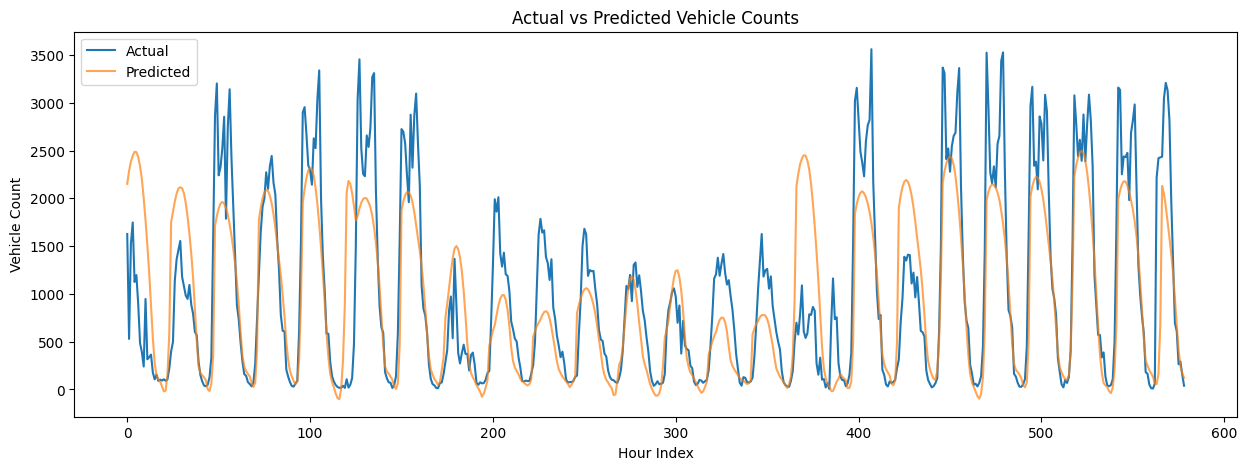

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_test = model.predict(X_test)

# inverse transform to get the actual vehicle counts
y_test_actual = scaler.inverse_transform(y_test)
y_pred_test_actual = scaler.inverse_transform(y_pred_test)

# performance metrics
mae = mean_absolute_error(y_test_actual, y_pred_test_actual)
mse = mean_squared_error(y_test_actual, y_pred_test_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_test_actual)
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R²):', r2)

# actual vs predicted vehicle counts
plt.figure(figsize=(15, 5))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_test_actual, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Vehicle Counts')
plt.xlabel('Hour Index')
plt.ylabel('Vehicle Count')
plt.legend()
plt.show()

After lots of hyperparamter tuning, the plot shows periods of closer alignment between actual and predicted values, indicative of model accuracy during those intervals. There are also instances where there is significant divergence is observed, which shows there is still room for model improvement.

The eval metrics are all "high", but for the data they make sense and show that the model can predict decently well but more features should be added to generate even better predictions.

In [ ]:
if len(test_hourly) > len(y_pred_test_actual):
    test_hourly = test_hourly.iloc[-len(y_pred_test_actual):].reset_index(drop=True) #sligght size mismatch

# new df w/ actual and predicted counts
test_hourly['actual_counts'] = y_test_actual.flatten()
test_hourly['predicted_counts'] = y_pred_test_actual.flatten()

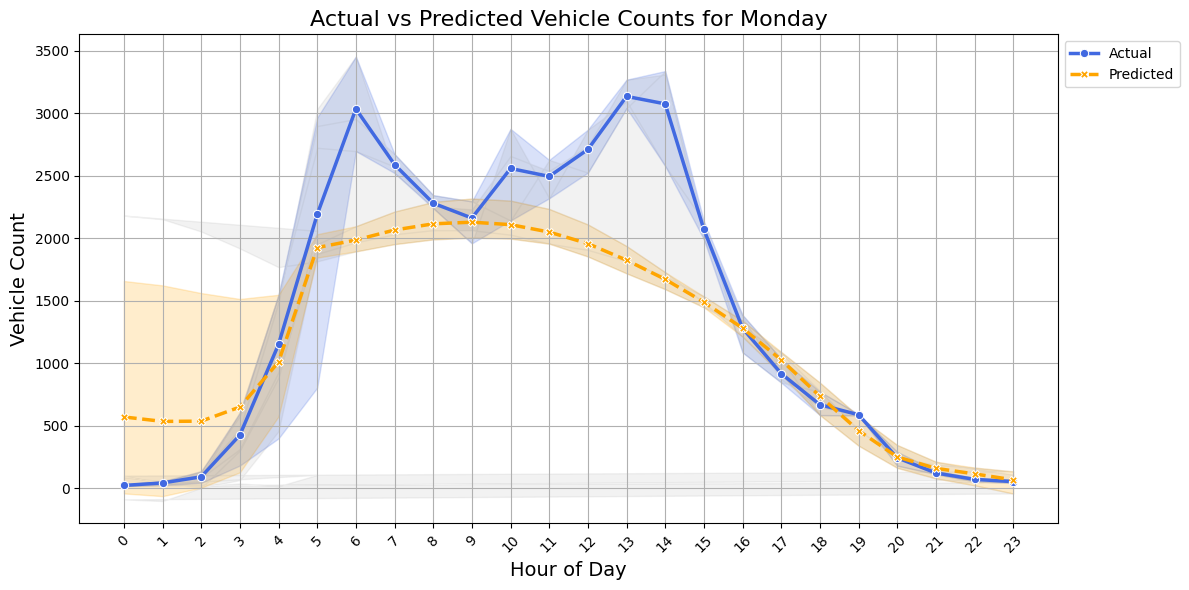

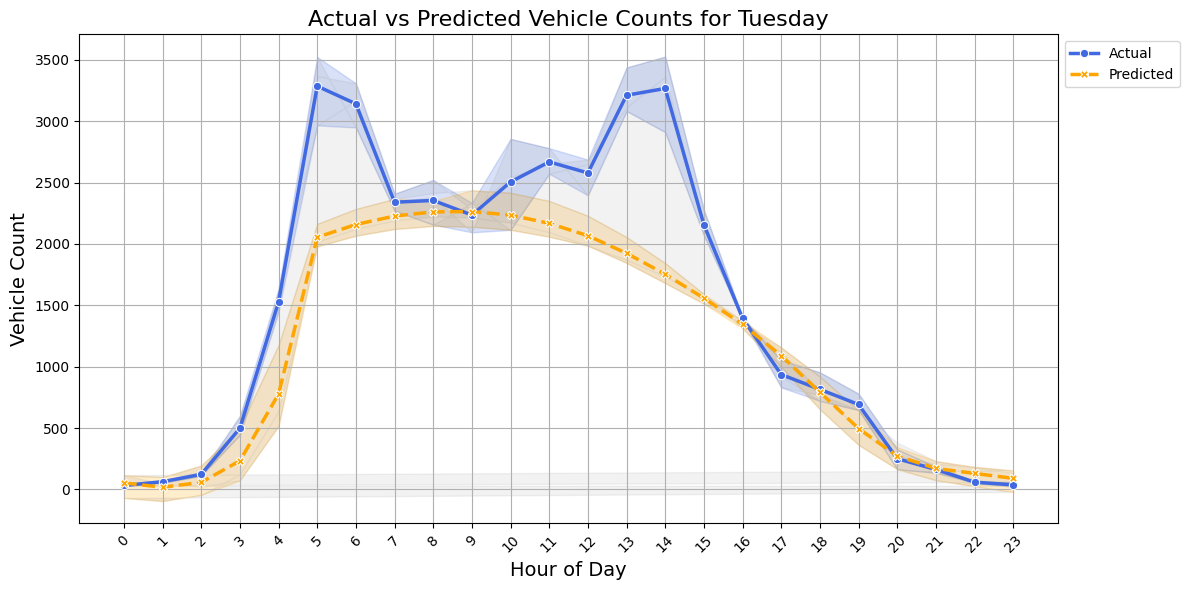

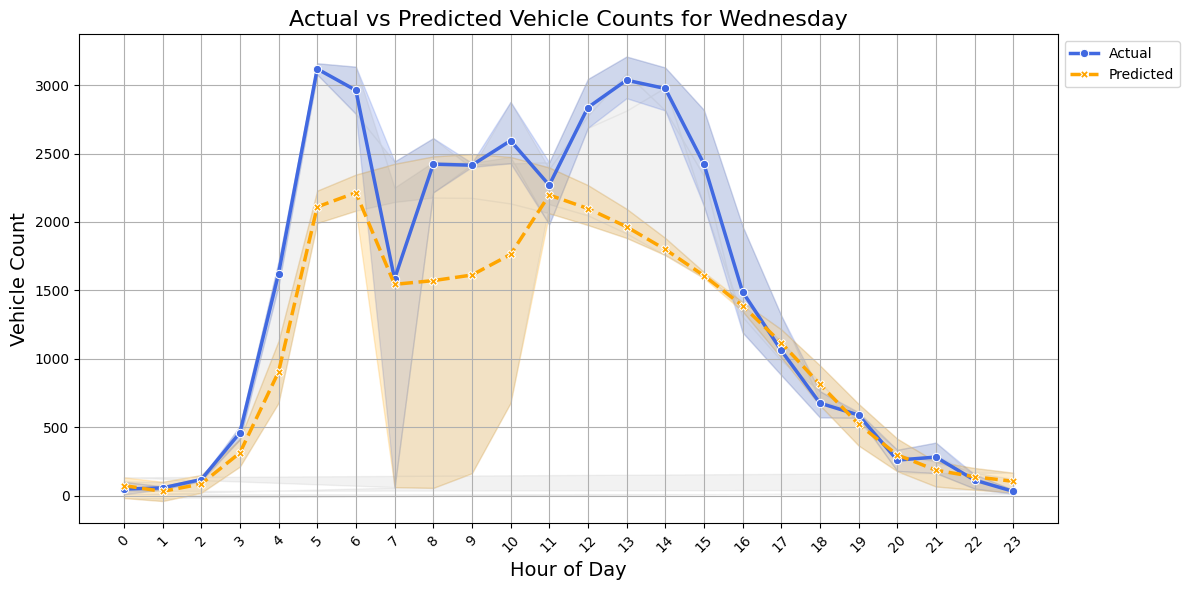

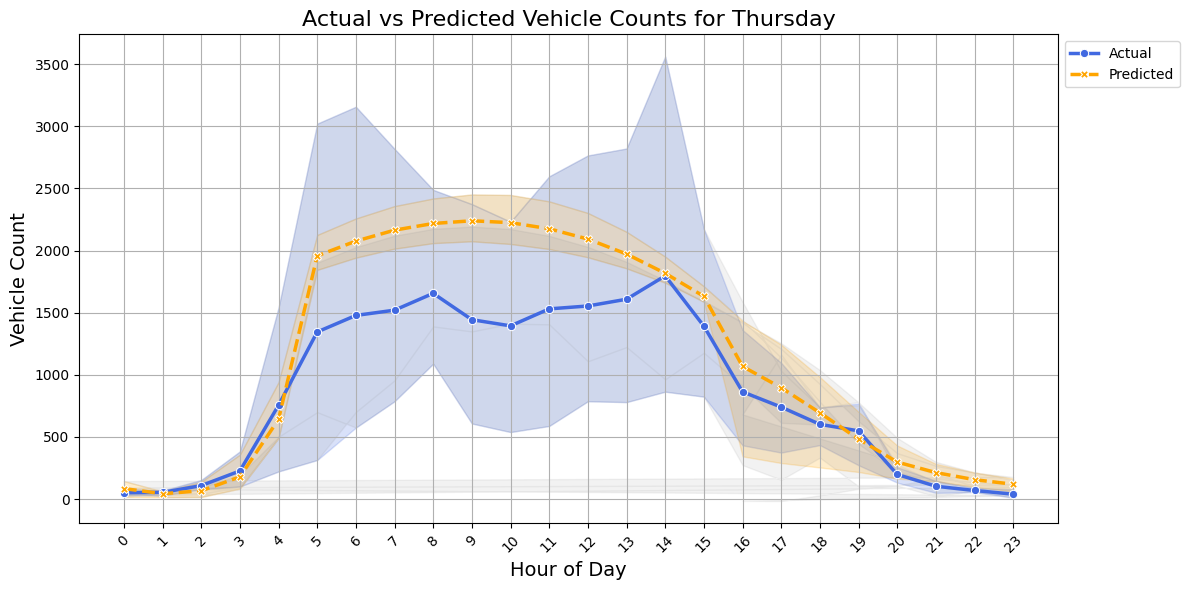

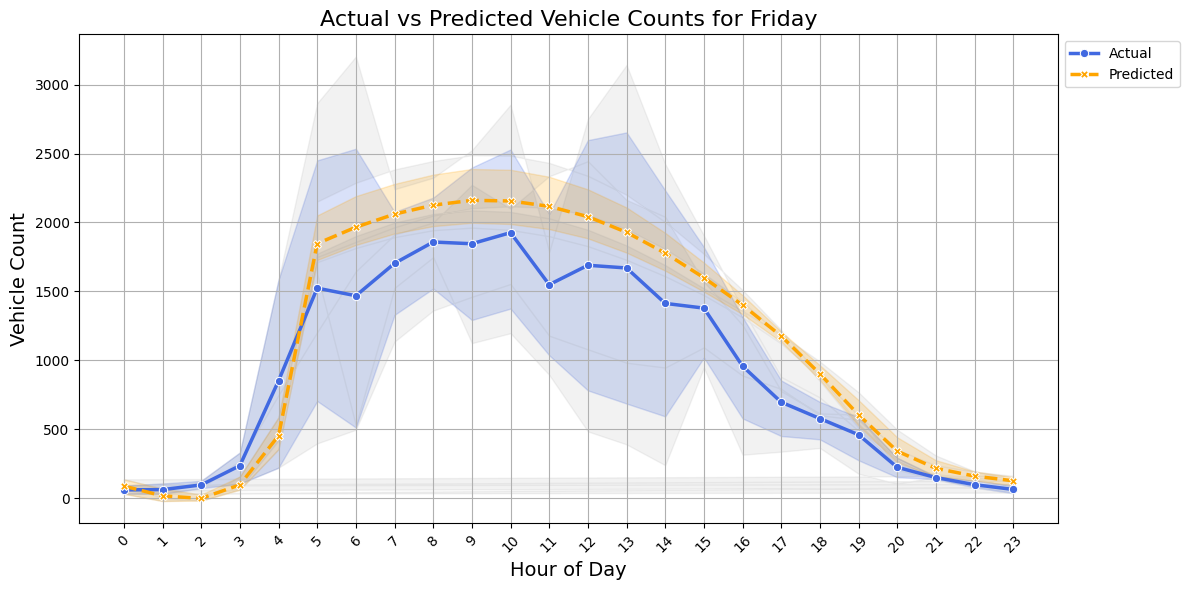

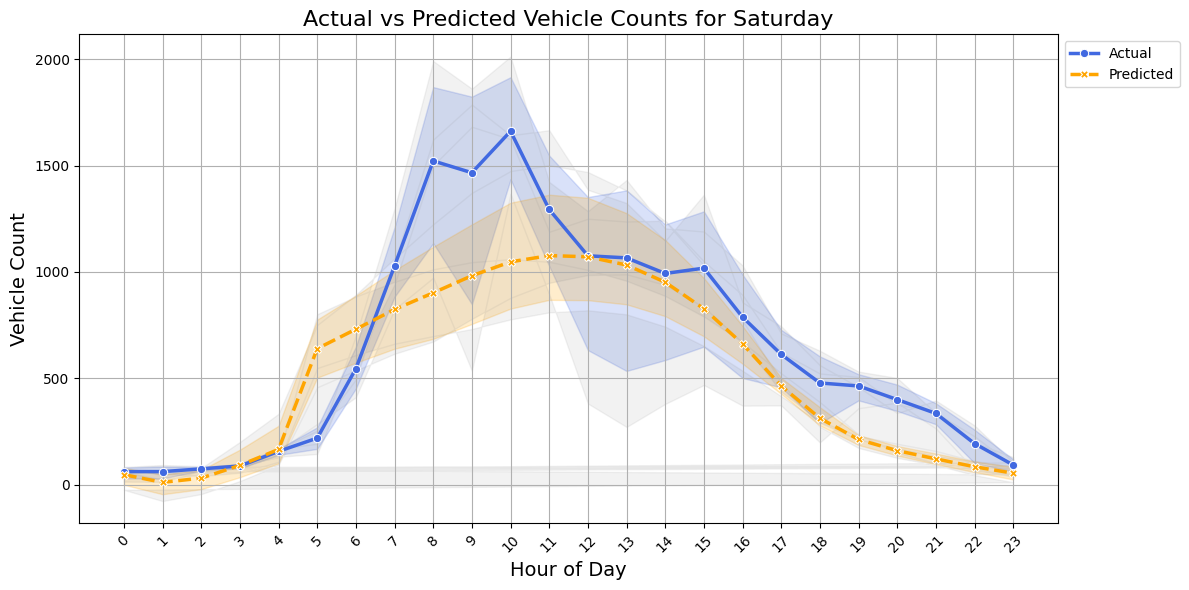

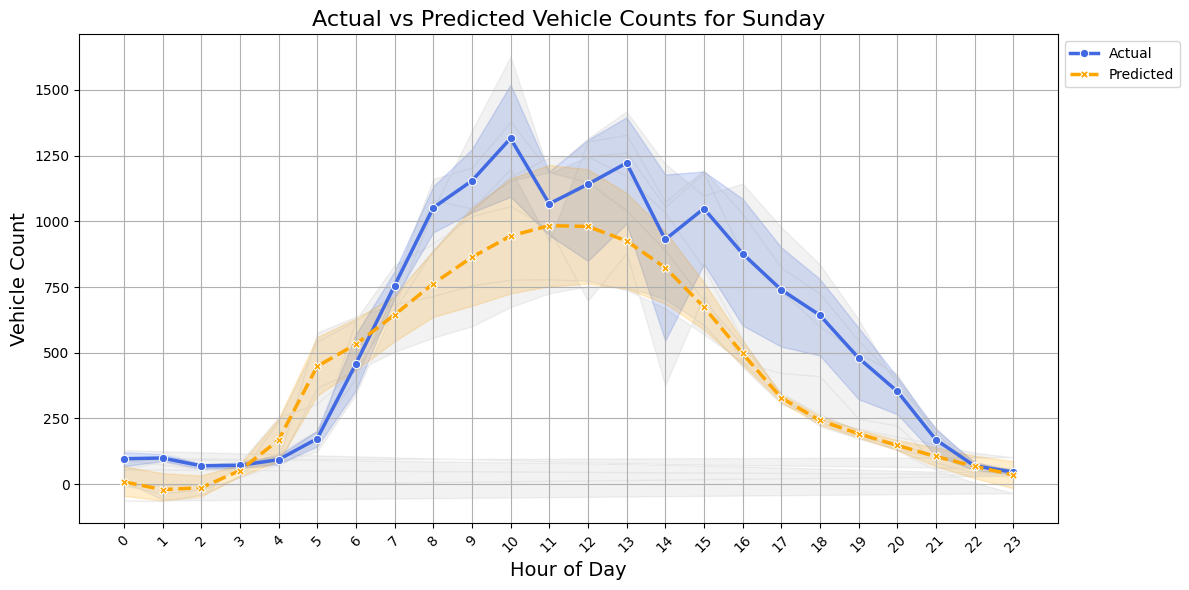

In [ ]:
# Plot for each day
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days_of_week:
    plt.figure(figsize=(12, 6))
    day_data = test_hourly[test_hourly['Day'] == day]

    # Plot actual vs predicted counts with enhancements
    sns.lineplot(data=day_data, x='Hour', y='actual_counts', label='Actual',
                 marker='o', linewidth=2.5, linestyle='-', color='royalblue')
    sns.lineplot(data=day_data, x='Hour', y='predicted_counts', label='Predicted',
                 marker='X', linewidth=2.5, linestyle='--', color='orange')

    plt.fill_between(day_data['Hour'], day_data['actual_counts'], day_data['predicted_counts'],
                     color='grey', alpha=0.1)

    plt.title(f'Actual vs Predicted Vehicle Counts for {day}', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Vehicle Count', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.xticks(range(0, 24, 1), rotation=45)
    plt.tight_layout()
    plt.show()


# Save Stuff

In [ ]:
model.save('/content/drive/MyDrive/IoT_Project/GRUCounts.keras')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/IoT_Project/RealCounts.keras')

In [ ]:
# saving chart data to csv and excel file
csv_file_path = '/content/drive/MyDrive/IoT_Project/GRU_predicted_vehicle_counts.csv'
test_hourly.to_csv(csv_file_path, index=False)

excel_file_path = '/content/drive/MyDrive/IoT_Project/GRU_predicted_vehicle_counts.xlsx'
test_hourly.to_excel(excel_file_path, index=False)